<a href="https://colab.research.google.com/github/giuliovv/ANNDL_competitions/blob/master/2_RNN/giulio_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

colab = "True" #@param ['True','False']
if colab == "True":
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/Colab Notebooks

Mounted at /gdrive
/gdrive/MyDrive/Colab Notebooks


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
plt.rcParams["figure.figsize"] = (20,10)

In [4]:
df = pd.read_csv("Training.csv")

In [5]:
df.head()

,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f69f8b8ff50>,
      dtype=object)

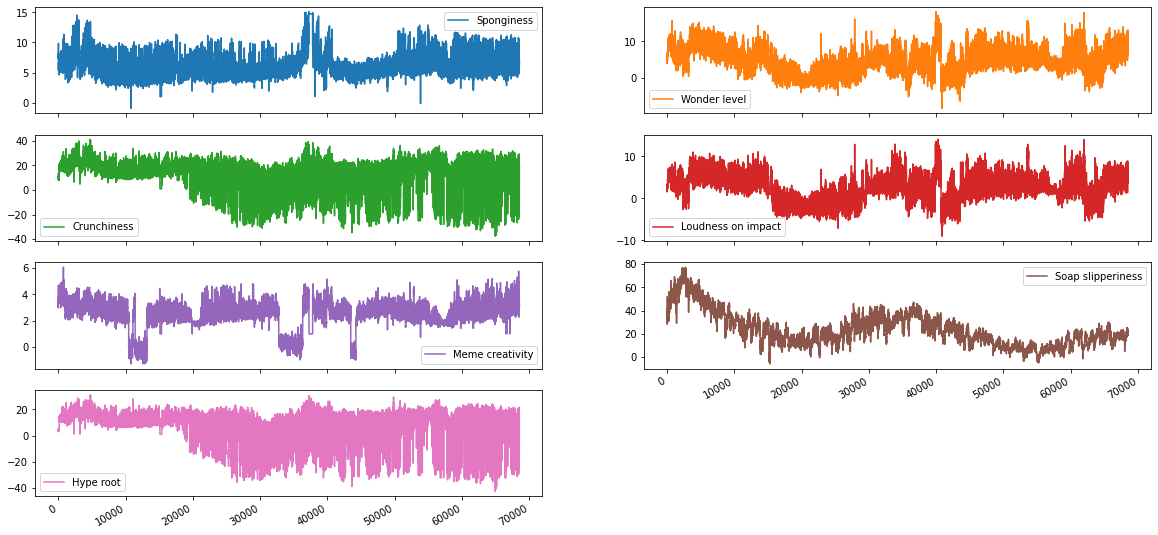

In [19]:
df.plot(subplots=True, layout=(4,2))